cpu


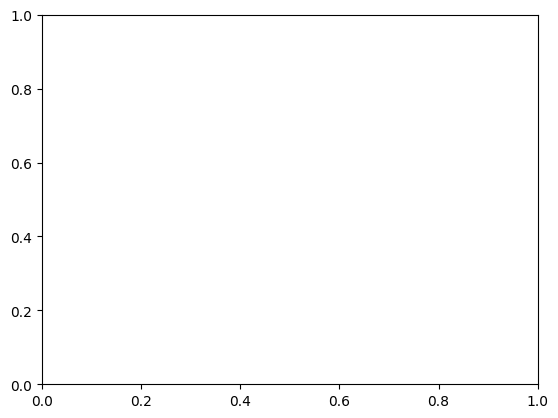

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
import utils
from data_utils import CustomDataset
from MLP_utils import load_model, save_model, fix_seed, SimpleMLP, LNLoss
import os
import pandas as pd
import pickle
import math

fix_seed(utils.SEED)

device = torch.device("cpu")
print(device)

brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]


plt.rcParams['figure.facecolor'] = ('white') 
plt.gca().set_facecolor('white')


plt.rcParams["figure.figsize"] = (6.8,7)
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
model, config = load_model('last_run', device=device)

In [3]:
config

{'criterion': MSELoss(),
 'optimizer': 'adam',
 'weight_decay': 0.00039931079168018907,
 'depth': 3,
 'width': 256,
 'lr': 7.069564548473013e-05,
 'batch_size': 1024,
 'max_epochs': 50,
 'patience': 3,
 'batchnorm': False,
 'dropout': 0.09829492149373525,
 'input_size': 4634,
 'filenames_features': ['brand_ohe.pt',
  'publication_timestamp_emb.pt',
  'publication_weekday_ohe.pt',
  'num_words.pt',
  'num_paragraph.pt',
  'main_section_emb.pt',
  'subsections_emb.pt',
  'user_needs.pt',
  'lda_topics.pt',
  'iptc_topics_level_0.pt',
  'iptc_topics_level_1.pt',
  'title_emb.pt',
  'author_ohe.pt',
  'labels_emb.pt',
  'time_indications_mentioned_emb.pt']}

In [4]:
brands = utils.ALL_BRANDS


customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=config["filenames_features"], 
                        dirpath_extracted_features=utils.DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device(device)
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

(4634, device(type='cpu'))

In [5]:
with open(os.path.join(utils.DIRPATH_INDICES, 'train_dataset_indices.pkl'), 'rb') as f:
    train_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'val_dataset_indices.pkl'), 'rb') as f:
    val_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'test_dataset_indices.pkl'), 'rb') as f:
    test_dataset_indices = pickle.load(f)
    
test_dataset = Subset(dataset, indices=test_dataset_indices)

In [6]:
with torch.no_grad():
    model.eval()
    metric = nn.MSELoss(reduction='none')
    metric = nn.L1Loss(reduction='none')

    y_test = dataset[test_dataset_indices][1]
    y_pred_test = model(dataset[test_dataset_indices][0])

    model_metric = metric(y_pred_test, y_test)
    model_metric = model_metric.squeeze()
    y_pred_test = y_pred_test.squeeze()

    baseline = torch.full_like(y_test, math.log(24) - dataset.centering_shift)
    baseline_metric = metric(y_test, baseline).squeeze()


    rfr_pred = torch.load('RFR_pred.pt')
    rfr_metric = metric(y_test.squeeze() + dataset.centering_shift, rfr_pred).squeeze()


Baseline - RFR:
tensor(0.3938) tensor(0.3598)
tensor(-0.2511) tensor(0.1895)
tensor(0.5674)


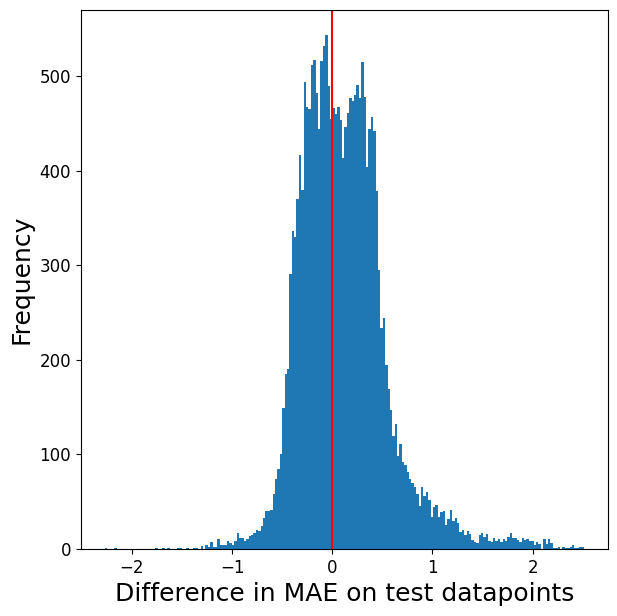

Baseline - MLP:
tensor(0.3746) tensor(0.3688)
tensor(-0.2075) tensor(0.1960)
tensor(0.6057)


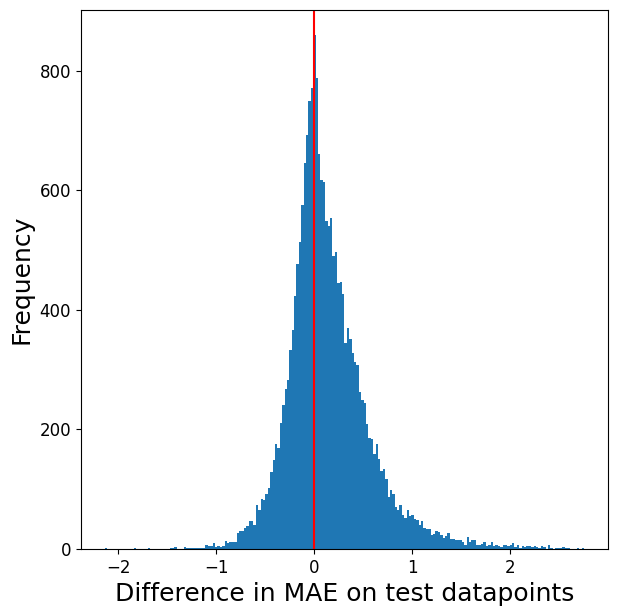

RFR - MLP:
tensor(0.1817) tensor(0.1525)
tensor(-0.1597) tensor(0.1363)
tensor(0.5564)


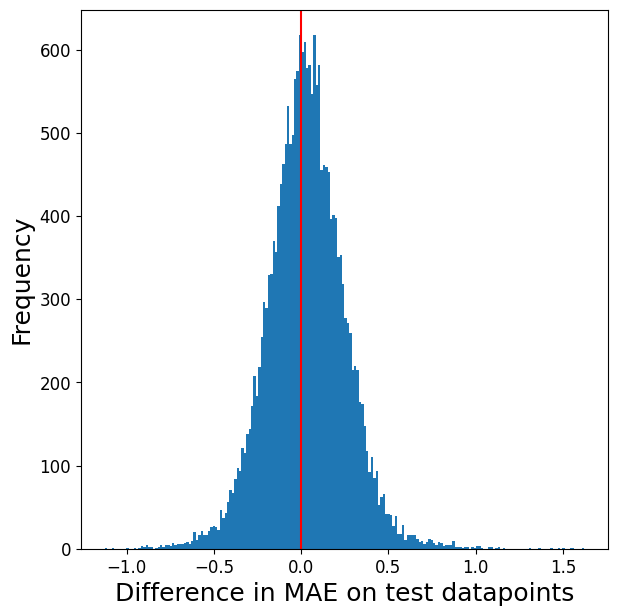

In [7]:
def plot_diff_metric_scores(scores1, scores2):
	diff = scores1 - scores2
	print(diff[diff>0].mean(), diff[diff>0].std())
	print(diff[diff<0].mean(), diff[diff<0].std())
	print(torch.mean((diff>0).float()))
	plt.hist(diff,bins=200)
	plt.axvline(x=0, c='r')
	plt.ylabel('Frequency')
	plt.xlabel('Difference in MAE on test datapoints')
	plt.show()

print('Baseline - RFR:')
plot_diff_metric_scores(baseline_metric, rfr_metric)

print('Baseline - MLP:')
plot_diff_metric_scores(baseline_metric, model_metric)

print('RFR - MLP:')
plot_diff_metric_scores(rfr_metric, model_metric)

In [9]:
data_pd = pd.concat([pd.read_csv(os.path.join(utils.DIRPATH_DATA, f"uva-relevance-windows-{brand_in_csv_filename}.csv"), sep=";")
                     for brand_in_csv_filename in brands_in_csv_filename], ignore_index=True)

In [49]:
# Sort by biggest difference between prediction MLP and RFR
rfr_pred_centered = rfr_pred - dataset.centering_shift
diff_sort_values, diff_sort_indices = torch.sort((rfr_pred_centered - y_pred_test).abs(), dim=0, descending=True)

In [100]:
print(f'Pred log RFR: {rfr_pred_centered[diff_sort_indices][:5]}')
print(f'Pred hours RFR: {torch.exp(rfr_pred_centered[diff_sort_indices] + dataset.centering_shift)[:5]}')
print(f'Pred log MLP:{y_pred_test[diff_sort_indices][:5]}')
print(f'Pred hours MLP: {torch.exp(y_pred_test[diff_sort_indices] + dataset.centering_shift)[:5]}')
print(f'Target Log: {y_test[diff_sort_indices][:5]}')
print(f'Target hours: {torch.exp(y_test[diff_sort_indices] + dataset.centering_shift)[:5]}')

Pred log RFR: tensor([-0.3239,  0.5283,  0.4388, -0.8157,  0.3609])
Pred hours RFR: tensor([21.0634, 49.3889, 45.1626, 12.8816, 41.7766])
Pred log MLP:tensor([1.2968, 2.0808, 1.9845, 0.6920, 1.8375])
Pred hours MLP: tensor([106.5065, 233.2832, 211.8570,  58.1752, 182.9054])
Target Log: tensor([[1.5485],
        [2.5474],
        [2.2562],
        [1.2437],
        [2.0753]])
Target hours: tensor([[137.0000],
        [372.0000],
        [278.0000],
        [101.0000],
        [232.0000]])


In [101]:
data_pd.iloc[torch.tensor(test_dataset_indices)[diff_sort_indices][:5].tolist()]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
119362,1a3913d,brabantsdagblad,2024-08-18 05:00:33+00:00,zondag,Ongewenst kinderloze proberen ‘ongewenst’ om t...,Lisanne van Sadelhoff (34) woont met haar Roem...,Lisanne van Sadelhoff (34) woont met haar Roem...,673,9,['a6ad8dd5-8399-3699-8b38-ea1b1198d7d4'],column,nieuws,mezza,"{'geef_me_context': 0.00386429438367486, 'help...",{'afval_en_milieuproblematiek': 0.000319183774...,"{'wetenschap en technologie': 0.5494, 'kunst, ...","{'sociale wetenschappen': 0.5494, 'cultuur': 0...",NaN,137.0
207884,eef8e4e,volkskrant,2024-07-26 19:37:20+00:00,vrijdag,Bekijk hier de medaillespiegel van de Olympisc...,De verwachtingen zijn hooggespannen: databurea...,De verwachtingen zijn hooggespannen: databurea...,23,1,['cb417c05-0fc8-32ae-955f-ac1238c6d5a6'],overzicht,sport,olympische-spelen,"{'geef_me_context': 0.13972881436347961, 'help...",{'afval_en_milieuproblematiek': 0.003356134984...,{'sport': 0.6145},{},NaN,372.0
117004,35be0e6,brabantsdagblad,2024-08-04 18:10:53+00:00,zondag,Deze kledingstukken móet je shoppen in de sale...,"Ook wie er niets mee heeft, denkt er één keer ...","Ook wie er niets mee heeft, denkt er één keer ...",248,6,['96f4093f-81c7-3553-a8b3-dbf2e6945255'],dresscode,nieuws,mezza,"{'geef_me_context': 0.0008751818095333874, 'he...",{'afval_en_milieuproblematiek': 0.000698120042...,"{'economie, zaken en financiën': 0.4215}",{'economische sector': 0.4215},zaterdag,278.0
191637,ffe3a5d,parool,2024-09-04 01:00:42+00:00,woensdag,Ronald Koeman wil hogere intensiteit en meer a...,Bondscoach Ronald Koeman eist richting WK meer...,Bondscoach Ronald Koeman eist richting WK meer...,694,16,['a989ea57-5be7-3427-aa4e-6b87dd1756b5'],exclusief,sport,NaN,"{'geef_me_context': 0.000429030362283811, 'hel...",{'afval_en_milieuproblematiek': 0.000244356546...,"{'sport': 0.7131, 'levensstijl en vrije tijd':...","{'wedstrijddiscipline': 0.6498, 'vrije tijd': ...","dinsdag,jaar,zaterdag",101.0
105349,f4aa956,brabantsdagblad,2024-06-02 05:00:11+00:00,zondag,Als een katje volg ik haar vanuit mijn donsfort,Beau ligt verfrommeld in bed ‘ Mannen hebben n...,Beau ligt verfrommeld in bed ‘ Mannen hebben n...,633,10,['88a8a119-1e27-3a98-a236-1fbfc632fa75'],column,nieuws,mezza,"{'geef_me_context': 0.0011465101270005107, 'he...",{'afval_en_milieuproblematiek': 0.000287099683...,"{'gezondheid': 0.8074, 'wetenschap en technolo...","{'ziekten en aandoeningen': 0.4853, 'gezondhei...","gistermiddag,vandaag",232.0


In [108]:
test_sort = torch.sort(model_metric, dim=0, descending=True)
test_sort_indices = torch.tensor(test_dataset_indices)[test_sort.indices]
test_sort_values = test_sort.values

test_pred = y_pred_test[test_sort.indices]
test_pred_hours = torch.exp(test_pred + dataset.centering_shift)

In [111]:
rfr_pred_centered[test_sort.indices]

tensor([-1.1405, -1.1471, -0.9734,  ..., -0.6274,  0.2055, -0.5394])

In [112]:
torch.exp(rfr_pred_centered[test_sort.indices] + dataset.centering_shift)

tensor([ 9.3083,  9.2479, 11.0020,  ..., 15.5506, 35.7632, 16.9796])

In [10]:
# Amount of errors you want to see
n_errors = 5

In [22]:
# predictions of n biggest errors
test_pred_hours[:n_errors]

tensor([ 7.5359, 12.1186, 11.8950,  9.9343,  8.4395])

In [118]:
test_pred

tensor([-1.3518, -0.8767, -0.8953,  ..., -0.3756,  0.4127, -0.5382])

In [109]:
test_sort_indices

tensor([176951, 176599, 183412,  ...,  79513,  17276, 104563])

In [102]:
test_sort_indices[:n_errors]

tensor([176951, 176599, 183412, 178752, 176978])

In [115]:
print(f'Target Log: {y_test[test_sort.indices][:n_errors]}')
print(f'Target hours: {torch.exp(y_test[test_sort.indices] + dataset.centering_shift)[:n_errors]}')

Target Log: tensor([[2.7422],
        [2.9529],
        [2.7598],
        [2.2195],
        [1.9661]])
Target hours: tensor([[452.0000],
        [558.0000],
        [460.0000],
        [268.0001],
        [208.0000]])


In [129]:
# n articles with biggest error
data_pd.iloc[test_sort_indices[:n_errors].tolist()]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
176951,6320875,nu,2024-07-16 07:40:53+00:00,dinsdag,Zorginstituut adviseert om afslankmiddel Wegov...,Het Zorginstituut Nederland adviseert minister...,Het Zorginstituut Nederland adviseert minister...,347,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0006683157407678664, 'he...",{'afval_en_milieuproblematiek': 0.000470316153...,{'gezondheid': 1},"{'ziekten en aandoeningen': 0.7924, 'gezondhei...",NaN,452.0
176599,6320378,nu,2024-07-11 14:59:00+00:00,donderdag,Mensen worden niet meer getest op chlamydia al...,De GGD gaat vanaf 2025 niet langer mensen test...,De GGD gaat vanaf 2025 niet langer mensen test...,424,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0004959646030329168, 'he...",{'afval_en_milieuproblematiek': 0.000401869212...,{'gezondheid': 0.8814},{'gezondheidsbehandeling': 0.7319},donderdag,558.0
183412,6329790,nu,2024-09-28 06:50:00+00:00,zaterdag,Bergwijn maakt zijn eerste doelpunt voor Al It...,Steven Bergwijn heeft vrijdagavond zijn eerste...,Steven Bergwijn heeft vrijdagavond zijn eerste...,173,1,['3c3127e2-b2f6-33b5-a644-b246440e7af2'],"steven bergwijn,voetbal",sport,voetbal,"{'geef_me_context': 0.0003729545860551298, 'he...",{'afval_en_milieuproblematiek': 0.000887690461...,"{'sport': 0.653, 'samenleving': 0.3652, 'leven...","{'wedstrijddiscipline': 0.6183, 'vrije tijd': ...",vrijdagavond,460.0
178752,6321913,nu,2024-08-05 03:16:56+00:00,maandag,Dagprogramma Olympische Spelen: 3x3-basketball...,De 3x3-basketballers gaan de finale strijden o...,De 3x3-basketballers gaan de finale strijden o...,502,1,['3c3127e2-b2f6-33b5-a644-b246440e7af2'],NaN,NaN,NaN,"{'geef_me_context': 0.0032618327531963587, 'he...",{'afval_en_milieuproblematiek': 0.037303239107...,{'sport': 1},{'wedstrijddiscipline': 0.9038},"dinsdag,morgen",268.0
176978,6320922,nu,2024-07-16 10:41:53+00:00,dinsdag,Medewerker politie Den Haag ontslagen na ongep...,De politie in Den Haag heeft een medewerker on...,De politie in Den Haag heeft een medewerker on...,193,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,discriminatie,"{'geef_me_context': 0.0003043769393116236, 'he...",{'afval_en_milieuproblematiek': 0.013928355649...,"{'politiek': 0.8199, 'misdaad, recht en gerech...","{'regering': 0.716, 'politie': 0.6519, 'wet': ...",dinsdag,208.0


In [ ]:
# random forest data loading
dataset_forest = pd.concat([pd.read_csv("./y_real.csv"), pd.read_csv("./y_pred.csv")], axis=1)
dataset_forest = dataset_forest.loc[:, ~dataset_forest.columns.duplicated()]
print(dataset_forest)
y_pred_test_forest = dataset_forest["pred_y"]
y_pred_test_forest = torch.tensor(y_pred_test_forest)
y_test_forest = dataset_forest["real_y"]
y_test_forest = torch.tensor(y_test_forest)
test_dataset_indices_forest = dataset_forest["Indices"]

with torch.no_grad():
    metric = nn.L1Loss(reduction='none')
    
    metric_score_test_forest = metric(y_pred_test_forest, y_test_forest)
    metric_score_test_forest = metric_score_test_forest.squeeze()
    y_pred_test_forest = y_pred_test_forest.squeeze()

In [130]:
brands_in_csv_filename = [
    "AD",
    "Brabants Dagblad",
    "DeStentor",
    "NU",
    "Het Parool",
    "Trouw",
    "De Volkskrant",
]
weekdays = [
	'Monday',
	'Tuesday',
	'Wednesday',
	'Thursday',
	'Friday',
	'Saturday',
	'Sunday'
]
user_needs=[
	'geef me context',
	'help me',
	'hou me op de hoogte',
	'raak me verbind me',
	'vermaak me'
]
LDA_topics = [
	'afval_en_milieuproblematiek', 
	'bestuur_en_organisatie',
	'bouwen_en_wonen',
	'brand',
	'consumeren_en_vrije_tijd',
	'duurzaamheid',
	'economie',
	'eten_en_drinken',
	'gemeentepolitiek',
	'gezondheid_en_zorg',
	'het_weer',
	'human_interest',
	'kunst_en_cultuur',
	'lokale_evenementen',
	'maatschappelijke_instellingen',
	'misdaad',
	'natuur',
	'nominatie_en_prijzen',
	'onderwijs',
	'optredens_en_voorstellingen',
	'overheidsbeleid',
	'politiek',
	'recht_en_justitie',
	'relatie_en_opvoeden',
	'religie',
	'samenleving',
	'sport',
	'technologie_en_handel',
	'vakbond_club_en_vereniging',
	'veiligheid',
	'verkeer',
	'verkeersongevallen',
	'voetbal',
	'wielrennen',
	'woon_en_leefomgeving',
	'zingeving_en_verhalen'
]

iptc_0_topics = [
	'economie, zaken en financiën',
	'sport',
	'misdaad, recht en gerechtigheid',
	'millieu',
	'het weer',
	'samenleving',
	'opleiding',
	'politiek',
	'arbeid',
	'conflict, oorlog en vrede',
	'religie en geloof',
	'levensstijl en vrije tijd',
	'menselijke interesse',
	'gezondheid',
	'ramp, ongeval en noodsituatie incident',
	'wetenschap en technologie',
	'kunst, cultuur, entertainment en media'
]

iptc_1_topics = ['wedstrijddiscipline', 'fundamentele rechten', 'mensheid', 'natuurwetenschap', 'cultuur', 'met pensioen', 'gezondheidsbehandeling', 'noodgeval', 'sociaal probleem', 'rechterlijke macht', 'technologie en techniek', 'wetenschappelijke instelling', 'demografie', 'markt en uitwisseling', 'sportorganisatie', 'overheidsgezondheidszorg', 'bedrijfsinformatie', 'natuur', 'religieus festival en vakantie', 'sociale wetenschappen', 'drugsgebruik in de sport', 'levensstijl', 'ziekten en aandoeningen', 'werk relaties', 'sport evenement', 'noodhulp', 'welzijn', 'godsdienstig onderwijs', 'familie', 'waarden', 'weersverschijnselen', 'ziektekostenverzekering', 'ongeval en noodgeval', 'bloemen en planten', 'economie', 'massa media', 'bloedbad', 'noodplanning', 'economische sector', 'toelatingsexamen', 'gemeenschappen', 'groep ouders', 'werkgelegenheid', 'werkloosheid', 'vakbonden', 'medisch beroep', 'weerswaarschuwing', 'wetenschappelijk onderzoek', 'maatschappelijke onrust', 'milieuvervuiling', 'gezondheidsfaciliteit', 'wiskunde', 'biomedische wetenschappen', 'religieuze leider', 'sociale conditie', 'politie', 'emigratie', 'ceremonie', 'internationale relaties', 'religieuze voorzieningen', 'kunst en vermaak', 'krijgsgevangenen', 'geloofssystemen', 'vredesproces', 'onderwijzen en leren', 'overheids beleid', 'discriminatie', 'sport industrie', 'gerechtigheid', 'sport transactie', 'gewapend conflict', 'weervoorspelling', 'disciplinaire maatregelen in de sport', 'ramp', 'terreurdaad', 'mensen', 'natuurlijke bronnen', 'klimaatverandering', 'gezondheidsorganisaties', 'wet', 'immigratie', 'school', 'politiek proces', 'dier', 'vrije tijd', 'misdrijf', 'leraren', 'verkiezing', 'leerplan', 'naoorlogse wederopbouw', 'educatieve testen en examens', 'arbeidswetgeving', 'studenten', 'religieuze tekst', 'sportlocatie', 'behoud', 'staatsgreep', 'regering']

#MLP
errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test, dataset[test_dataset_indices][0].cpu(), y_test, y_pred_test, test_dataset_indices)]
#RFR
#errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test_forest, dataset[test_dataset_indices_forest][0].cpu(), y_test_forest, y_pred_test_forest, test_dataset_indices_forest)]

errors.sort(reverse=True, key=lambda x: x[0])

brand_all_indices = [0 for _ in range(7)]
weekday_all_indices = [0 for _ in range(7)]
user_needs_all_indices = [0 for _ in range(5)]
LDA_all_indices = [0 for _ in range(36)]
iptc_0_all_indices = [0 for _ in range(17)]
iptc_1_all_indices = [0 for _ in range(98)]
for err in errors[:22000]:
	brand_all_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_all_indices[brand_all_index] += 1
	weekday_all_index, _ = max(enumerate(err[1][9:16]), key=lambda x: x[1])
	weekday_all_indices[weekday_all_index] += 1
	user_needs_all_index, _ = max(enumerate(err[1][618:623]), key=lambda x: x[1])
	user_needs_all_indices[user_needs_all_index] += 1
	LDA_all_index, _ = max(enumerate(err[1][623:659]), key=lambda x: x[1])
	LDA_all_indices[LDA_all_index] += 1
	iptc_0_all_index, _ = max(enumerate(err[1][659:676]), key=lambda x: x[1])
	iptc_0_all_indices[iptc_0_all_index] += 1
	iptc_1_all_index, _ = max(enumerate(err[1][676:774]), key=lambda x: x[1])
	iptc_1_all_indices[iptc_1_all_index] += 1

print_total_appearances = False
if print_total_appearances:
	print("brands:")
	for i in range(len(brand_all_indices)):
		print(f"{i}.{brands_in_csv_filename[i]}: {brand_all_indices[i]}")
	print()
	print("weekdays:")
	for i in range(len(weekday_all_indices)):
		print(f"{i}.{weekdays[i]}: {weekday_all_indices[i]}")
	print()
	print("user_needs:")
	for i in range(len(user_needs_all_indices)):
		print(f"{i}.{user_needs[i]}: {user_needs_all_indices[i]}")
	print()
	print("LDA_topics:")
	for i in range(len(LDA_all_indices)):
		print(f"{i}.{LDA_topics[i]}: {LDA_all_indices[i]}")
	print()
	print("iptc_0_topics:")
	for i in range(len(iptc_0_all_indices)):
		print(f"{i}.{iptc_0_topics[i]}: {iptc_0_all_indices[i]}")
	print()
	print("iptc_1_topics:")
	for i in range(len(iptc_1_all_indices)):
		print(f"{i}.{iptc_1_topics[i]}: {iptc_1_all_indices[i]}")

brand_max_indices = [0 for _ in range(7)]
weekday_max_indices = [0 for _ in range(7)]
user_needs_max_indices = [0 for _ in range(5)]
LDA_max_indices = [0 for _ in range(36)]
iptc_0_max_indices = [0 for _ in range(17)]
iptc_1_max_indices = [0 for _ in range(98)]

for err in errors[:300]:
	#print(f"Error: {err[0]:.4f}, True Value: {err[2]:.4f}, Predicted: {err[3]:.4f}, Index: {err[4]:.4f}")
	brand_max_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_max_indices[brand_max_index] += 1
	weekday_max_index, _ = max(enumerate(err[1][9:16]), key=lambda x: x[1])
	weekday_max_indices[weekday_max_index] += 1
	user_needs_max_index, _ = max(enumerate(err[1][618:623]), key=lambda x: x[1])
	user_needs_max_indices[user_needs_max_index] += 1
	LDA_max_index, _ = max(enumerate(err[1][623:659]), key=lambda x: x[1])
	LDA_max_indices[LDA_max_index] += 1
	iptc_0_max_index, _ = max(enumerate(err[1][659:676]), key=lambda x: x[1])
	iptc_0_max_indices[iptc_0_max_index] += 1
	iptc_1_max_index, _ = max(enumerate(err[1][676:774]), key=lambda x: x[1])
	iptc_1_max_indices[iptc_1_max_index] += 1

LDA_max_indices = [0 if LDA_all_indices[i] < 100 else LDA_max_indices[i] for i in range(len(LDA_max_indices))]
iptc_0_max_indices = [0 if iptc_0_all_indices[i] < 100 else iptc_0_max_indices[i] for i in range(len(iptc_0_max_indices))]
iptc_1_max_indices = [0 if iptc_1_all_indices[i] < 100 else iptc_1_max_indices[i] for i in range(len(iptc_1_max_indices))]

brand_max_indices = [brand_max_indices[i] / brand_all_indices[i] for i in range(7)]
weekday_max_indices = [weekday_max_indices[i] / weekday_all_indices[i] for i in range(7)]
user_needs_max_indices = [user_needs_max_indices[i] / user_needs_all_indices[i] for i in range(5)]
LDA_max_indices = [LDA_max_indices[i] / LDA_all_indices[i] if LDA_all_indices[i] != 0 else 0 for i in range(36)]
iptc_0_max_indices = [iptc_0_max_indices[i] / iptc_0_all_indices[i] if iptc_0_all_indices[i] != 0 else 0 for i in range(17)]
iptc_1_max_indices = [iptc_1_max_indices[i] / iptc_1_all_indices[i] if iptc_1_all_indices[i] != 0 else 0 for i in range(98)]

brand_max_indices = [(brand_max_indices[i] / sum(brand_max_indices)) * 100 for i in range(7)]
weekday_max_indices = [(weekday_max_indices[i] / sum(weekday_max_indices)) * 100 for i in range(7)]
user_needs_max_indices = [(user_needs_max_indices[i] / sum(user_needs_max_indices)) * 100 for i in range(5)]
LDA_max_indices = [(LDA_max_indices[i] / sum(LDA_max_indices)) * 100 for i in range(36)]
iptc_0_max_indices = [(iptc_0_max_indices[i] / sum(iptc_0_max_indices)) * 100 for i in range(17)]
iptc_1_max_indices = [(iptc_1_max_indices[i] / sum(iptc_1_max_indices)) * 100 for i in range(98)]

plt.pie(brand_max_indices, labels=brands_in_csv_filename)
plt.show()

weekday_max_indices_s = weekday_max_indices[-2:] + weekday_max_indices[:-2]
plt.pie(weekday_max_indices_s, labels=weekdays)
plt.show()

plt.pie(user_needs_max_indices, labels=user_needs)
plt.show()

plt.pie(LDA_max_indices, labels=LDA_topics)
plt.show()

plt.pie(iptc_0_max_indices, labels=iptc_0_topics)
plt.show()

plt.pie(iptc_1_max_indices, labels=iptc_1_topics)
plt.show()

NameError: name 'metric_score_test' is not defined